In [1]:
%matplotlib notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

<IPython.core.display.Javascript object>


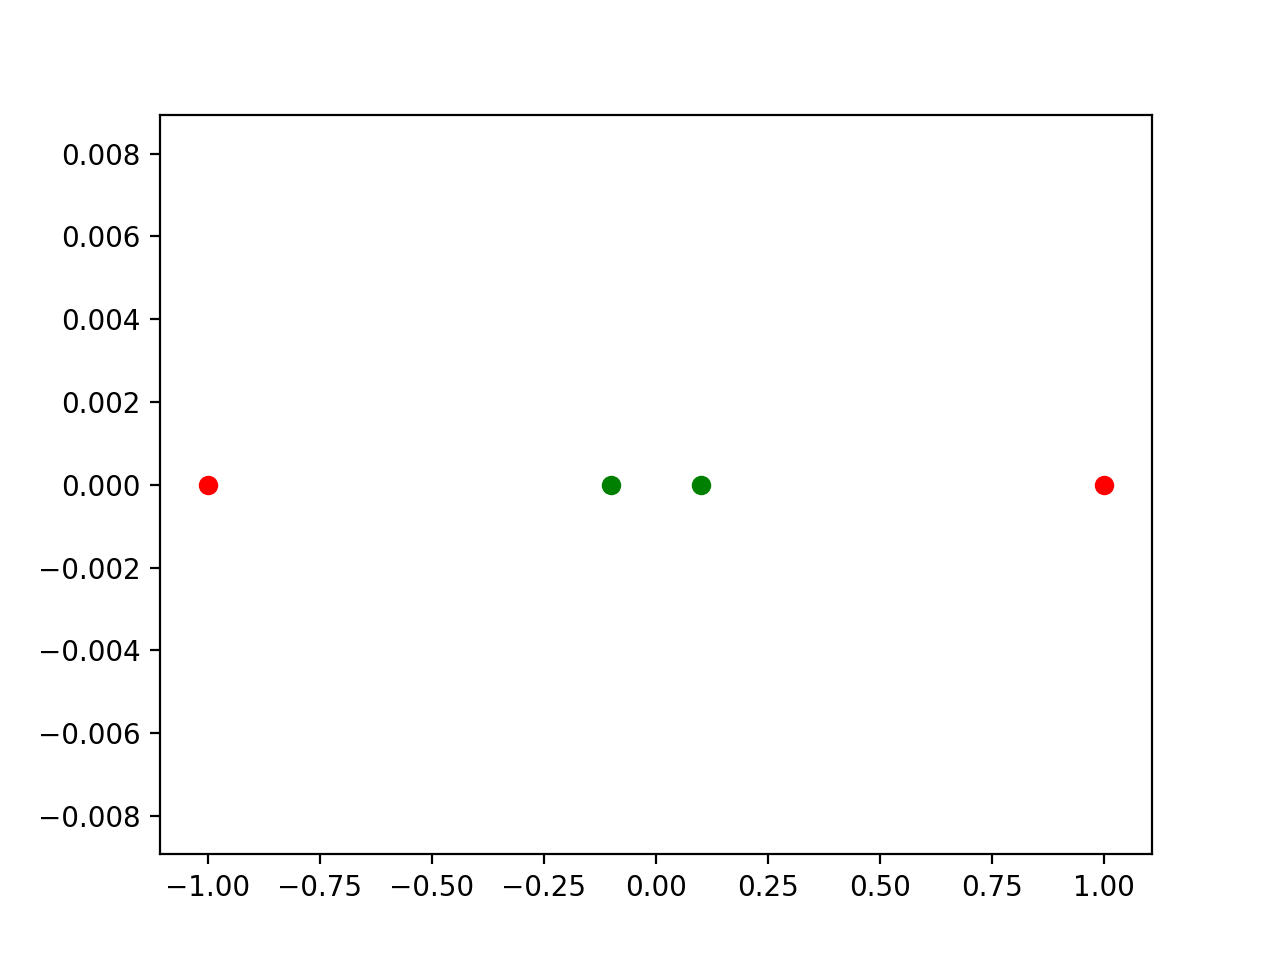

In [2]:
random.seed(3)

def rand_cluster(n,c,r):
    """returns n random points in disk of radius r centered at c"""
    x = c
    points = []
    for i in range(n):
        theta = 2*math.pi*random.random()
        s = r*random.random()
        points.append([x+s*math.cos(theta)])
    return points

def rand_clusters(k,n,r, a,b,c,d):
    """return k clusters of n points each in random disks of radius r
    where the centers of the disk are chosen randomly in [a,b]x[c,d]"""
    clusters = []
    for _ in range(k):
        x = a + (b-a)*random.random()
        y = c + (d-c)*random.random()
        clusters.extend(rand_cluster(n,x,r))
    return clusters

n = 2
X = rand_clusters(2,n,0.8,-1,1,-1,1)
data = np.array(X)
label = np.transpose(np.array([[1]*n + [0]*n]))

# label = np.array([1]*n + [0]*n)
data = []
label = []
data.append([-1])
data.append([1])
data.append([0.1])
data.append([-0.1])
label.append([1])
label.append([1])
label.append([0])
label.append([0])
data = np.array(data)
label = np.array(label)
# print (data, label)

plt.scatter(data[:n], [0]*n, color=['red'])
plt.scatter(data[n:], [0]*n, color=['green'])
plt.show()

In [24]:
# tf.reset_default_graph()

# def weight_variable(shape, name):
#     initial = tf.truncated_normal(shape=shape, stddev=0.1)
#     return tf.get_variable(name=name, initializer=initial)

# def bias_variable(shape, name):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.get_variable(name=name, initializer=initial)


x = tf.placeholder(tf.float32, [None, 1])
y_ = tf.placeholder(tf.float32, [None, 1])


n_input = 1
n_hidden = 2
n_output = 1
lmd = 0


rang = 1.
parameters = tf.Variable(tf.concat([#tf.truncated_normal([n_input * n_hidden]), 
                                    tf.random_uniform([7], minval= -rang, maxval= rang),
                                   ], 0))
# parameters = tf.Variable(tf.concat([tf.truncated_normal([n_input * n_hidden]), tf.zeros([n_hidden]),\
#                                     tf.truncated_normal([n_hidden * n_output]), tf.zeros([n_output]),\
#                                    ], 0))

idx_from = 0 
weights1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_input*n_hidden]), [n_input, n_hidden])
idx_from = idx_from + n_input*n_hidden
biases1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden]), [n_hidden])
hidden = tf.nn.sigmoid(tf.matmul(x, weights1) + biases1)

idx_from = idx_from + n_hidden
weights2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden*n_output]), [n_hidden, n_output])
idx_from = idx_from + n_hidden*n_output
biases2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_output]), [n_output])
y = tf.nn.sigmoid(tf.matmul(hidden, weights2) + biases2)

loss = tf.reduce_mean(tf.reduce_sum(tf.pow(y_ - y, 2), reduction_indices=[1])) #I also tried simply tf.nn.l2_loss(y_ - y)

lr = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
grads_and_vars = optimizer.compute_gradients(loss)
grad = tf.gradients(loss, parameters)
hess = tf.hessians(loss, parameters)
train_step = optimizer.apply_gradients(grads_and_vars)

In [25]:
def cg(A, b, it, x=None):
#     A: 2d numpy.array of positive semi-definite (symmetric) matrix
#     b: 1d numpy.array
#     x: 1d numpy.array of initial point

    A = np.array(A)
    b = np.array(b)
#     print (A, b)
    n = len(b)
    if not x:
        x = np.ones(n)
    r = np.dot(A, x) - b
    p = - r
    r_k_norm = np.dot(r, r)
    for i in range(it):
        Ap = np.dot(A, p)
        alpha = r_k_norm / np.dot(p, Ap)
        if alpha < 0:
            print ('Neg Itr:', i)
            return p
        x += alpha * p
        r += alpha * Ap
        r_kplus1_norm = np.dot(r, r)
        beta = r_kplus1_norm / r_k_norm
        r_k_norm = r_kplus1_norm
        if r_kplus1_norm < 1e-5:
            print ('Itr:', i)
            break
        p = beta * p - r
    return x

In [26]:
def get_accuracy():
    pred = sess.run(y, feed_dict={x: data, y_: label})    
    match = [(pred[i] - 0.5) * (label[i] - 0.5) > 0  for i in range(n*2)]
    acc = sum(match)*1./2/n
    return acc[0]

def get_norm_grad():
    nng = 0.
    for gv in grad:
#         print(str(sess.run(gv[0], feed_dict={x: data, y_: label})) + " - " + gv[1].name)
        g = sess.run(gv, feed_dict={x: data, y_: label})
#         print (g)
        nng += np.linalg.norm(g) ** 2
    return np.sqrt(nng)
    
     
def displayH(a):
    a = np.array(a[0])
#     print ("Matrix["+("%d" %a.shape[0])+"]["+("%d" %a.shape[1])+"]")
    rows = a.shape[0]
    cols = a.shape[1]
    for i in range(0, rows):
        for j in range(0, cols):
            print("%0.2g " %a[i,j], end="")
        print ()
    print ()

In [27]:
sess = tf.InteractiveSession()
dic = {}
nr = 10
cgIt = 5
stepsize = [1e-0, 1e-1, 1e-2]

for r in range(nr):
    
    tf.global_variables_initializer().run()
    v0, g, H, w = sess.run([loss, grad, hess, parameters], feed_dict={x: data, y_: label})    
    w0 = w
    
    d = cg(H[0], g[0], cgIt)
    rt = []
    for ss in stepsize:
        w_gd = w0 - ss * g[0]
        private_init = parameters.assign(w_gd)
        sess.run(private_init)    
        v_gd = sess.run(loss, feed_dict={x: data, y_: label})    

        w_cg = w0 - ss * d
        private_init = parameters.assign(w_cg)
        sess.run(private_init)    
        v_cg = sess.run(loss, feed_dict={x: data, y_: label})    
        
        rt.append((v_gd-v0) / (v_cg-v0) )
    print (rt)
sess.close() 

Neg Itr: 1
[13.686916, 14.761905, 13.888889]
Itr: 1
[0.23243667, 0.11554749, 0.10857143]
Neg Itr: 2
[-431.89978, -411.7037, -373.0]
Neg Itr: 1


/Users/Schemmy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in float_scalars


[249.44, 226.66667, -inf]
Neg Itr: 1
[26.604849, 27.664722, 27.57971]
Neg Itr: 2
[-2024.1338, -2184.7856, -inf]
Neg Itr: 2
[-1035.7944, -901.48389, -937.0]
Neg Itr: 2
[2.1557512, 2.675271, 2.7422361]
Neg Itr: 2
[-15.559662, -16.115385, -15.854167]
Neg Itr: 1
[-211.0677, -226.17949, -222.25]


<IPython.core.display.Javascript object>


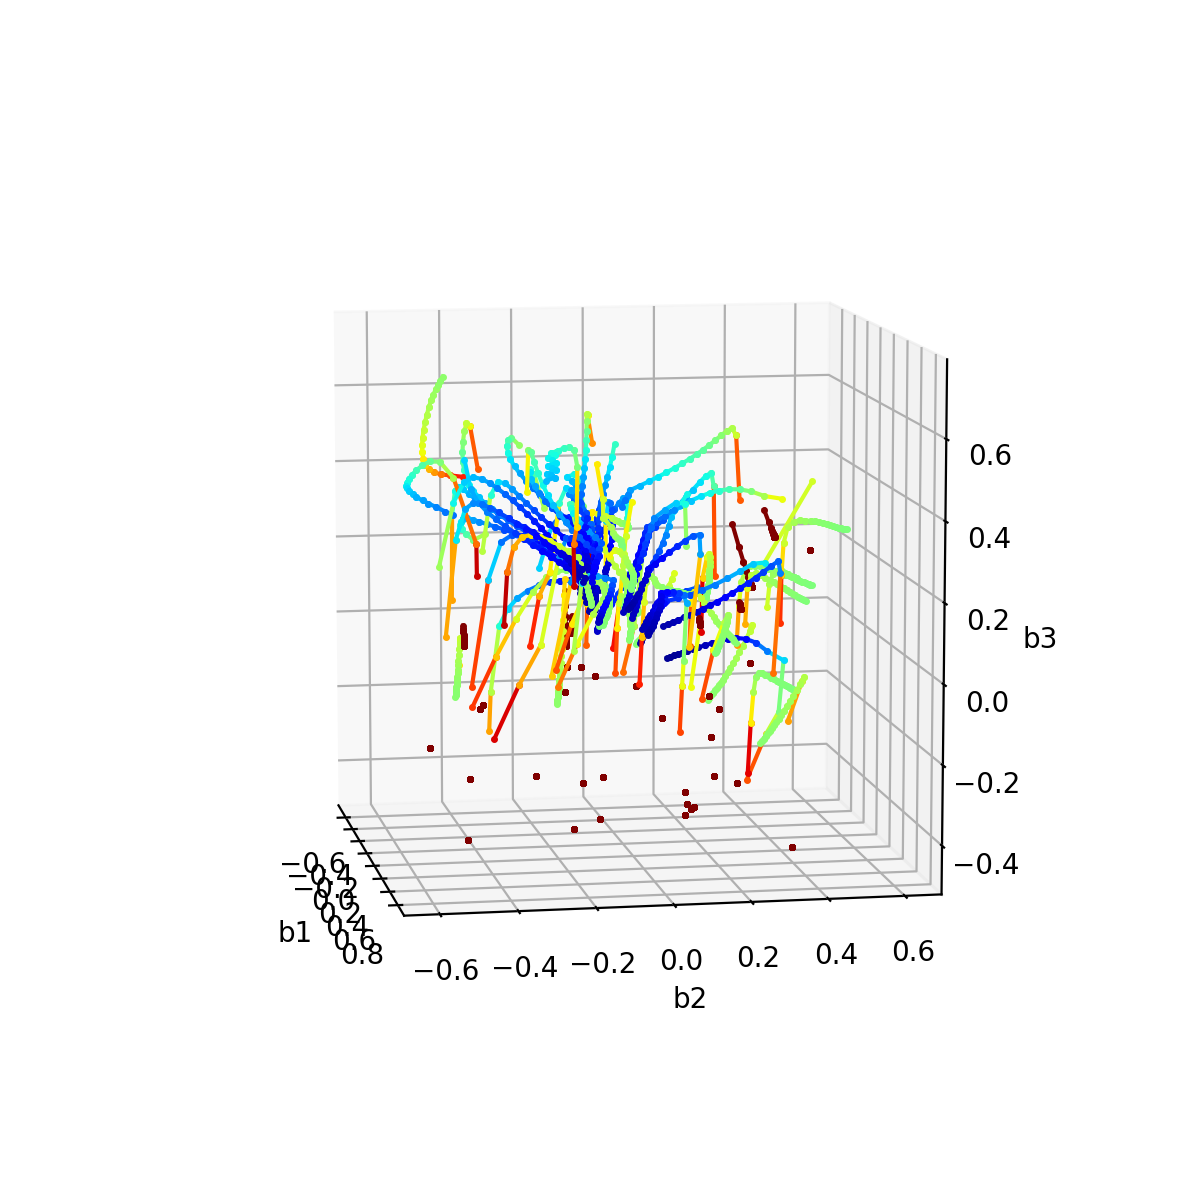

In [101]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s'][i]*2) for i in range(ni-1)])
    for i in range(ni-1):
        pp = ax.plot(dic[r]['b1'][i:i+2], dic[r]['b2'][i:i+2], dic[r]['b3'][i:i+2]
                , marker='o', markersize=1.5)

ax.set_xlabel('b1')
ax.set_ylabel('b2')
ax.set_zlabel('b3')
plt.show()

<IPython.core.display.Javascript object>


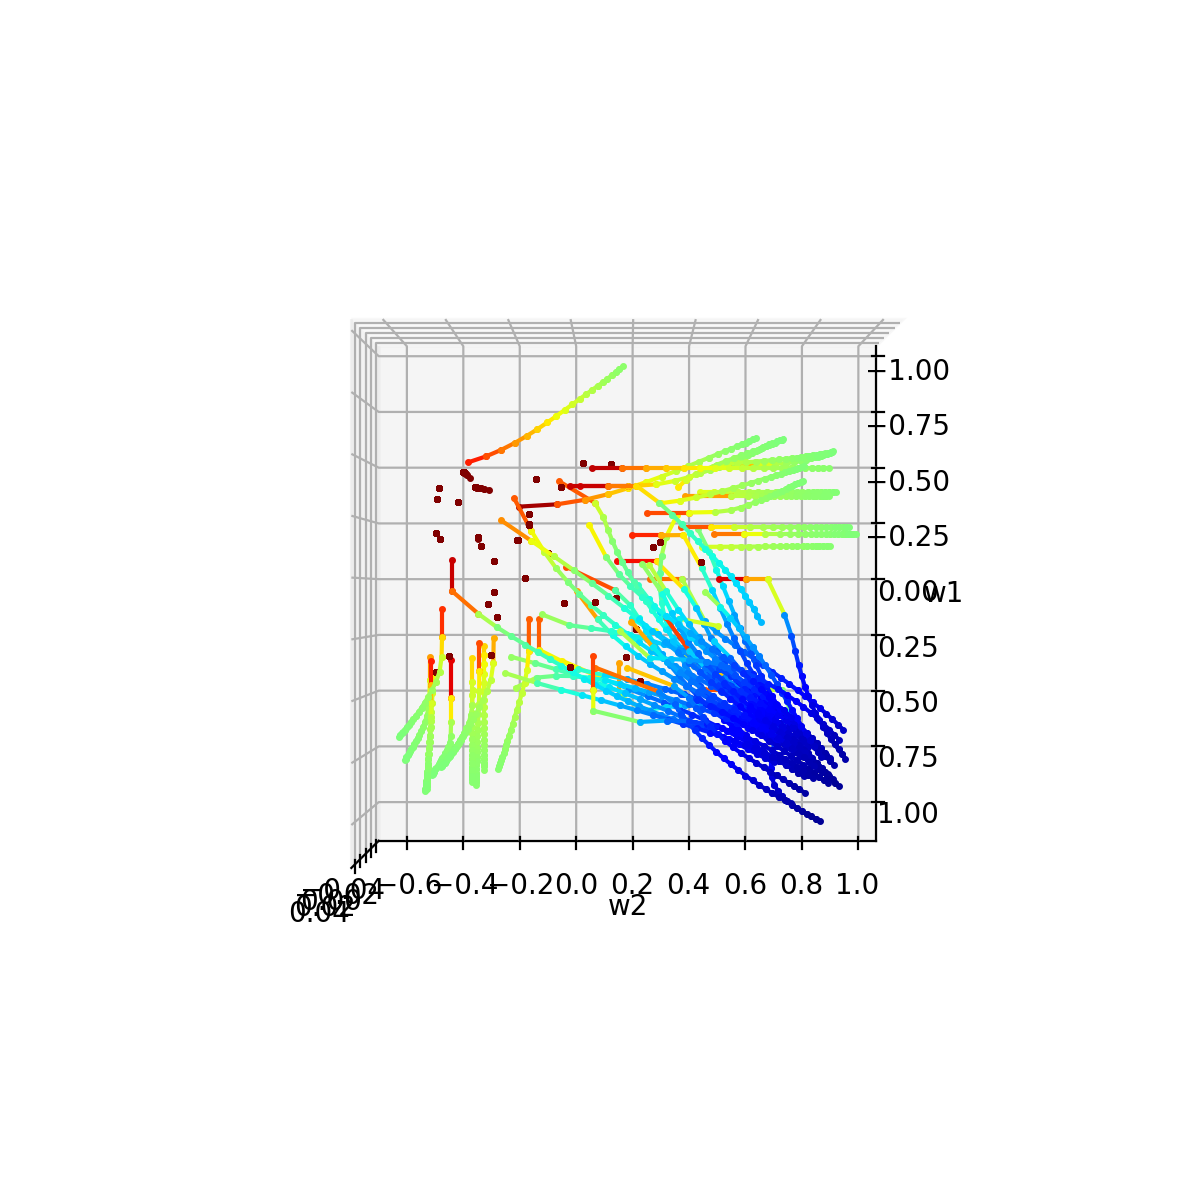

In [102]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s'][i]*2) for i in range(ni-1)])
    for i in range(ni-1):
        ax.plot(dic[r]['w1'][i:i+2], dic[r]['w2'][i:i+2]
                , marker='o', markersize=1.5)

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.view_init(elev=90., azim=0)
plt.show()

In [115]:
sess = tf.InteractiveSession()
l = 3e-1
dic = {}
nr = 1000

cmap = cm.brg  # nipy_spectral, Set1, Paired, brg
colors = cm.jet(np.linspace(0.8, 0.3, ni+1))
colors[:, 1] = np.linspace(0.5, 0.5, ni+1)
colors[:, 2] = np.linspace(0., 0.0, ni+1)

for r in range(nr):
    
    dic[r] = {}
    tf.global_variables_initializer().run()
    v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
#     nng = get_norm_grad()
    dic[r]['w1'] = w[2]
    dic[r]['w2'] = w[3]
    dic[r]['b1'] = w[0]
    dic[r]['b2'] = w[1]
    dic[r]['b3'] = w[4]
    dic[r]['s'] = max(v,1e-5)
#     eigs = sorted(np.linalg.eigvals(H)[0])
#     print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
#             .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:]), max(eigs), min(eigs) ))

sess.close() 

<IPython.core.display.Javascript object>


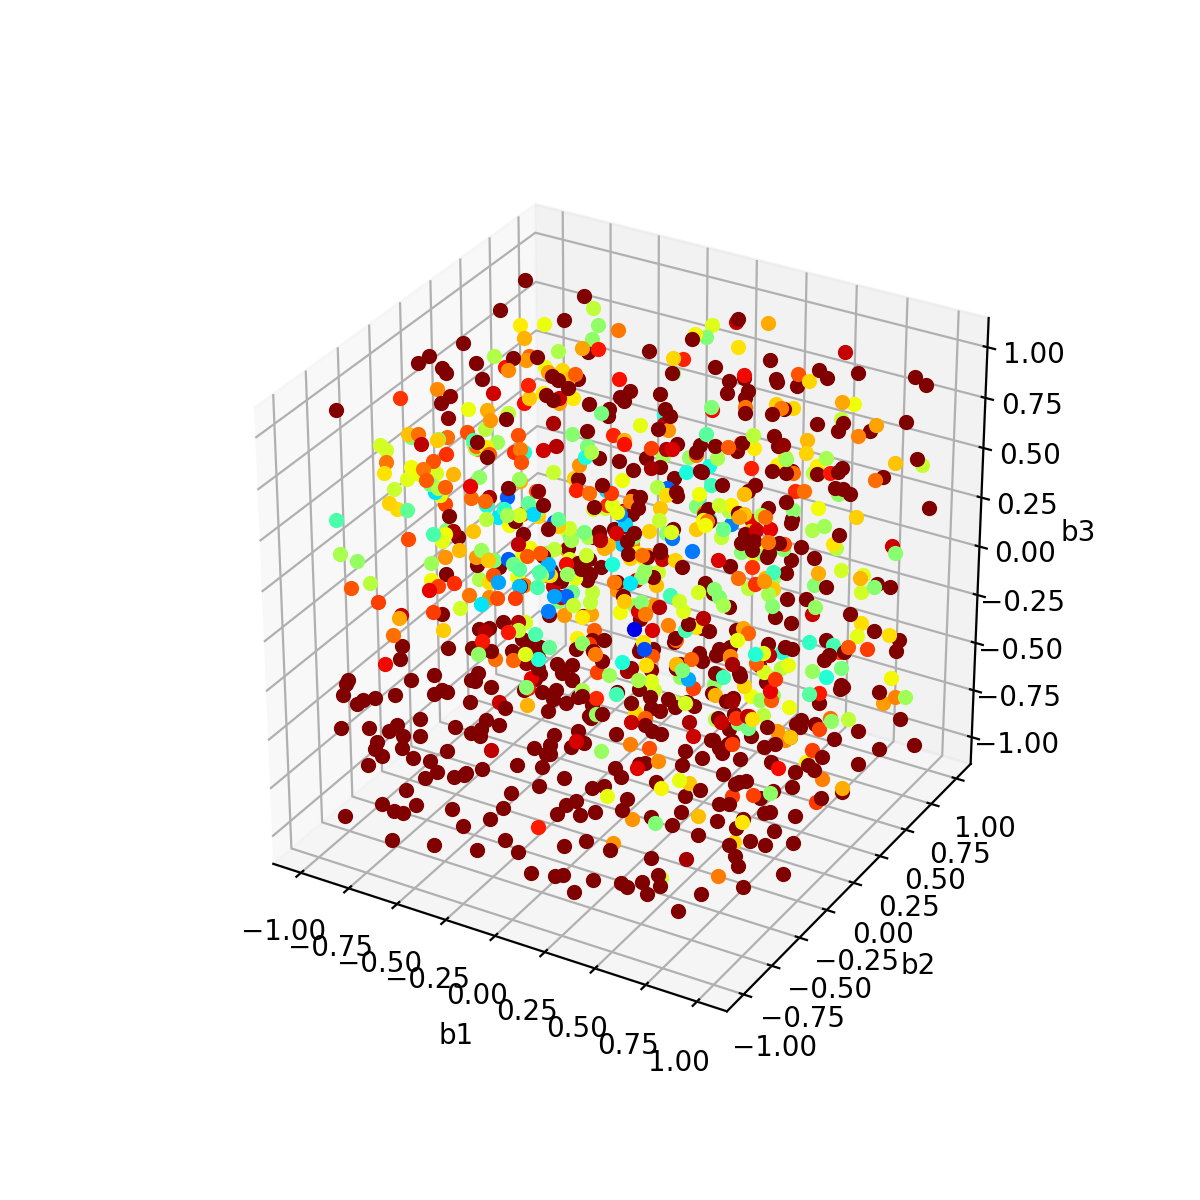

In [116]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s']*2)])
    pp = ax.scatter(dic[r]['b1'], dic[r]['b2'], dic[r]['b3'])

ax.set_xlabel('b1')
ax.set_ylabel('b2')
ax.set_zlabel('b3')
plt.show()

<IPython.core.display.Javascript object>


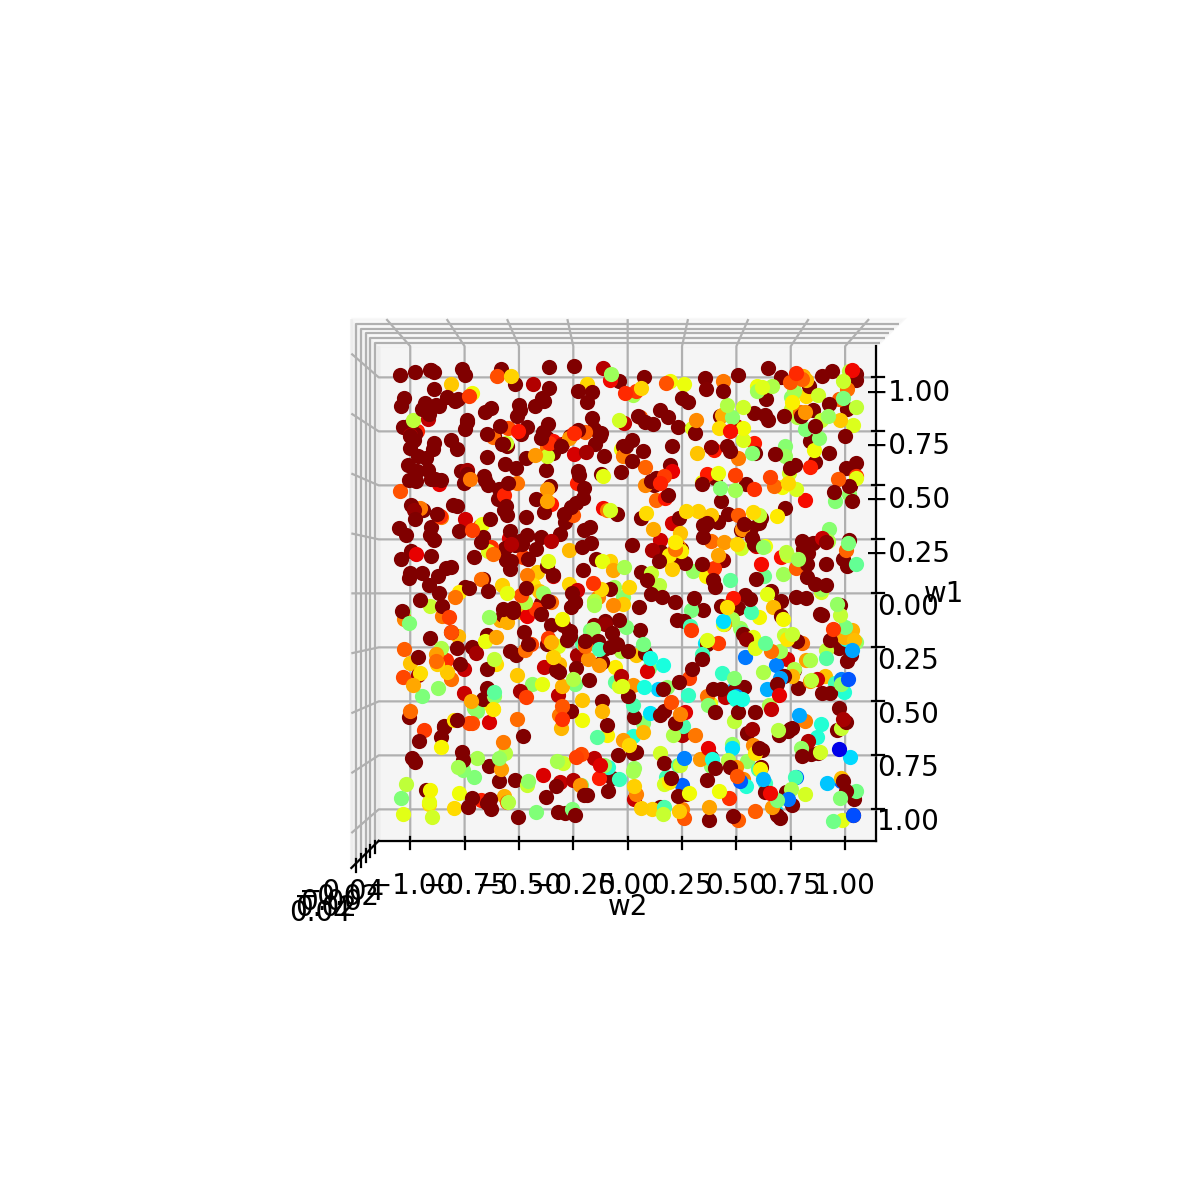

In [117]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
cmap = plt.get_cmap('jet')

for r in range(nr):
#     print ([cm(dic[r]['s'][i]/10) for i in range(ni-1)])
    ax.set_prop_cycle('color', [cmap(dic[r]['s']*2)])
    ax.scatter(dic[r]['w1'], dic[r]['w2'])

ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.view_init(elev=90., azim=0)
plt.show()